# Download Keras checkpoints from our GitHub repo

In [1]:
!mkdir -p rspincs/variables
!wget https://github.com/Google-Health/genomics-research/raw/main/regle/saved_models/rspincs/saved_model.pb -P rspincs/
!wget https://github.com/Google-Health/genomics-research/raw/main/regle/saved_models/rspincs/keras_metadata.pb -P rspincs/
!wget https://github.com/Google-Health/genomics-research/raw/main/regle/saved_models/rspincs/variables/variables.data-00000-of-00001 -P rspincs/variables/
!wget https://github.com/Google-Health/genomics-research/raw/main/regle/saved_models/rspincs/variables/variables.index -P rspincs/variables/

--2024-06-07 18:05:13--  https://github.com/Google-Health/genomics-research/raw/main/regle/saved_models/rspincs/saved_model.pb
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Google-Health/genomics-research/main/regle/saved_models/rspincs/saved_model.pb [following]
--2024-06-07 18:05:13--  https://raw.githubusercontent.com/Google-Health/genomics-research/main/regle/saved_models/rspincs/saved_model.pb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1227084 (1.2M) [application/octet-stream]
Saving to: ‘rspincs/saved_model.pb’

saved_model.pb      100%[===================>]   1.17M  --.-KB/s    in 

# Imports and functions

In [2]:
from typing import Optional

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
# The example values for the 5 (standardized) spigrogram EDFs:
# 'blow_fev1', 'blow_fvc', 'blow_pef', 'blow_ratio', 'blow_fef25_75'
EDF_VALUE_EXAMPLE = [-1.8, -1.8, -1.4, -0.7, -1.5]

# Note we use 0, 1, ..., 999 for the volume values in flow-volume curves,
# which were interpolated between 0 and 6.58.
VOLUME_SCALE_FACTOR = 6.58 / 1000


def _draw_double_arrow(
    ax: mpl.axes.Axes,
    x1: float,
    x2: float,
    y: float,
    arrow_color: str = '#d62728',
):
  """Draw an arrow pointing both sides between (x1, y) and (x2, y)."""
  ax.arrow(
      x1,
      y,
      x2 - x1,
      0,
      fc=arrow_color,
      ec=arrow_color,
      width=0.04,
      head_width=0.15,
      head_length=0.05,
      zorder=100,
  )
  ax.arrow(
      x2,
      y,
      x1 - x2,
      0,
      fc=arrow_color,
      ec=arrow_color,
      width=0.04,
      head_width=0.15,
      head_length=0.05,
      zorder=100,
  )


def generate_rspincs_reconstruction_plot(
    vae_model: tf.keras.Model,
    latent_dim: int,
    fpath_noext: Optional[str] = None,
    dpi=300,
) -> None:
  """Generate reconstructed spirograms while varying each RSPINCs coordinate.

  Args:
    row: A row of the SPINCs DF from which we'll get the values of manual
      features.
    vae_model: The VAE model to be used to reconstruct spirograms.
    latent_dim: The latent dimension.
    fpath_noext: The path to the output image file without extension.
    dpi: DPI of the image.
  """
  cmap = plt.get_cmap('viridis')
  num_injected_features = 5
  radius = 1.5
  single_encodings = np.linspace(-radius, radius, num=21)
  decoder = vae_model.get_layer(f'{vae_model.name}_decoder')
  colorbar_width = 0.2

  rescaled_volume = np.arange(1000) * VOLUME_SCALE_FACTOR
  _, axs = plt.subplots(
      1,
      latent_dim + 1,
      figsize=(4 * latent_dim + colorbar_width, 3),
      width_ratios=[4] * latent_dim + [colorbar_width],
  )

  for latent_idx in range(latent_dim):
    ax = axs[latent_idx]
    for img_idx, single_encoding in enumerate(single_encodings):
      # This value should be in [0, 1].
      color_val = single_encoding / (radius * 2) + 0.5
      encoding = np.zeros(latent_dim)
      encoding[latent_idx] = single_encoding
      encoding_input = np.expand_dims(encoding, axis=0)
      edf_input = np.expand_dims(np.array(EDF_VALUE_EXAMPLE), axis=0)
      vae_input = np.concatenate((encoding_input, edf_input), axis=-1)
      assert vae_input.shape == (1, latent_dim + num_injected_features)
      reconstructed = decoder(vae_input)[0].numpy()[:, 0]
      assert len(rescaled_volume) == len(reconstructed)
      ax.plot(
          rescaled_volume,
          reconstructed,
          color=cmap(color_val),
          alpha=0.9,
          linewidth=0.8,
      )
    ax.set_xlim((-20 * VOLUME_SCALE_FACTOR, 350 * VOLUME_SCALE_FACTOR))
    ax.set_ylim((-0.1, 4.2))
    ax.set_xlabel('Volume (L)')
    # Custom annotation for RSPINCs with dim = 2:
    if latent_idx == 0:
      ax.set_ylabel('Flow (L/s)')
      _draw_double_arrow(
          ax, 50 * VOLUME_SCALE_FACTOR, 140 * VOLUME_SCALE_FACTOR, 3
      )
    elif latent_idx == 1:
      _draw_double_arrow(
          ax, 5 * VOLUME_SCALE_FACTOR, 40 * VOLUME_SCALE_FACTOR, 3
      )
    ax.set_title('$\mathrm{RSPINC}_' + f'{latent_idx + 1}$')
  # Draw a color palette on the last axis.
  cbar = plt.colorbar(
      mpl.cm.ScalarMappable(
          norm=mpl.colors.Normalize(vmin=-radius, vmax=radius), cmap=cmap
      ),
      cax=axs[-1],
  )
  cbar.ax.set_xlabel('Coordinate\nValue')
  plt.tight_layout()
  plt.show()

# Load model and generate spirograms from embedding coordinate perturbation

In [4]:
rspincs_model = tf.keras.models.load_model('rspincs')

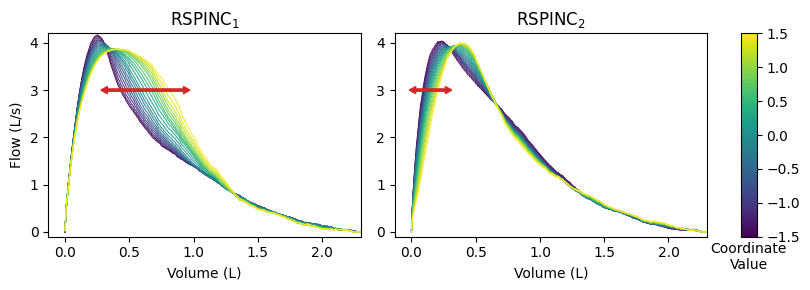

In [5]:
generate_rspincs_reconstruction_plot(
    vae_model=rspincs_model,
    latent_dim=2,
)